In [1]:
%load_ext rpy2.ipython 

In [2]:
%%R 
w_max=20 # max wild-type plasmids
m_max=30 # max mutant plasmids

nt_init=matrix(0,nrow=w_max+1,ncol=m_max+1)
w_init=w_max
m_init=0
nt_init[w_init+1,m_init+1]=3.12e9
rownames(nt_init)=paste0('w',0:w_max)
colnames(nt_init)=paste0('m',0:m_max)

In [3]:
%%R 
cell_division_old <- function(nt){
  nt_div=matrix(0,nrow=w_max+1,ncol=m_max+1)
  rownames(nt_div)=paste0('w',0:w_max)
  colnames(nt_div)=paste0('m',0:m_max)
  for(a in 0:w_max){ # loop over the entire population
    for(b in 0:m_max){ 
      if((a+b)>=1){ # require a+b>0
        
        for(jpk in 0:(a+b)){ # loop over the total number of plasmids in first cell
          p_jpk=dbinom(jpk,a+b,0.5) # binomial distribution
          
          for(j in max(0,jpk-b):min(a,jpk)){
            new=p_jpk*dhyper(j,a,b,jpk)*nt[a+1,b+1]
            nt_div[j+1,jpk-j+1]=nt_div[j+1,jpk-j+1]+new # cell 1
            nt_div[a-j+1,b-(jpk-j)+1]=nt_div[a-j+1,b-(jpk-j)+1]+new # cell 2
          }
        }
      }
    }
  }
  return (nt_div)
}

cell_division <- function(nt){
  nt_div=nt*0
  for(a in 0:w_max){ # loop over the entire population
    for(b in 0:m_max){ 
      
      p_nt=dbinom(0:(a+b),a+b,0.5)*nt[a+1,b+1] # binomial distribution * number of cells
      for(jpk in 0:(a+b)){ # loop over the total number of plasmids in first cell
        j_all=max(0,jpk-b):min(a,jpk) # number of wild-type plasmids in first cell
        new_all=p_nt[jpk+1]*dhyper(j_all,a,b,jpk) # number of cells
        # row=j_all+1
        # column=jpk-j_all+1
        # element=(column-1)*(w_max+1)+(row)
        nt_div[(jpk-j_all)*(w_max+1)+j_all+1]=nt_div[(jpk-j_all)*(w_max+1)+j_all+1]+new_all # cell 1
        # row=a-j_all+1
        # column=b-(jpk-j_all)+1
        # element=(column-1)*(w_max+1)+(row)
        nt_div[(b-jpk+j_all)*(w_max+1)+a-j_all+1]=nt_div[(b-jpk+j_all)*(w_max+1)+a-j_all+1]+new_all # cell 1
      }
    }
  }
  return (nt_div)
}


In [4]:
%%R 
#u # wt -> mutant rate
#r # wt plasmid growth rate
#R # mutant plasmid growth rate 

plasmid_replication_mutation_old <- function(nt_div,u,r,R){
    nt_growth=matrix(0,nrow=w_max+1,ncol=m_max+1)
    rownames(nt_growth)=paste0('w',0:w_max)
    colnames(nt_growth)=paste0('m',0:m_max)
    
    for(a in 0:w_max){ # loop over the entire population
      for(b in 0:m_max){ 
        a_plus1=floor(a*r)
        b_plus1=floor(b*R)
        
        new_wt=a_plus1-a
        w_to_m=0:new_wt
          
        a_plus2=a_plus1-w_to_m
        b_plus2=b_plus1+w_to_m
    
        a_plus2=ifelse (a_plus2<=w_max,a_plus2,w_max)

        for (i in 0:new_wt) {
          if(b_plus2[i+1]<=m_max)
              nt_growth[a_plus2[i+1]+1,b_plus2[i+1]+1]=
                  nt_growth[a_plus2[i+1]+1,b_plus2[i+1]+1] +
                  nt_div[a+1,b+1]*dbinom(i,new_wt,u)
        }
      }       
    }
    return (nt_growth)   
}

plasmid_replication_mutation <- function(nt_div,u,r,R){
  nt_growth=nt_div*0
  
  for(a in 0:w_max){ # loop over the entire population
    a_plus1=floor(a*r)
    new_wt=a_plus1-a
    w_to_m=0:new_wt
    a_plus2=a_plus1-w_to_m
    a_plus2=ifelse(a_plus2<=w_max,a_plus2,w_max) ##### this is not in the model
    
    p_w_to_m=dbinom(w_to_m,new_wt,u)
    
    for(b in 0:m_max){ 
      b_plus1=floor(b*R)
      b_plus2=b_plus1+w_to_m
      
      new=nt_div[a+1,b+1]*p_w_to_m
      for (i in w_to_m[b_plus2<=m_max]+1){
          nt_growth[a_plus2[i]+1,b_plus2[i]+1]=nt_growth[a_plus2[i]+1,b_plus2[i]+1]+new[i]
      }
      
    }       
  }
  return (nt_growth)   
}

In [5]:
%%R 
#S # baseline growth rate 
#m_optimal # NOTE: need m_optimal<m_max 
#m_lethal # NOTE: need m_optimal<m_lethal<=m_max

cell_selection_old <-function(nt_growth, S, m_optimal, m_lethal){
    nt_selection=matrix(0,nrow=w_max+1,ncol=m_max+1)
    rownames(nt_selection)=paste0('w',0:w_max)
    colnames(nt_selection)=paste0('m',0:m_max)
    
    for(a in 0:w_max){ # loop over the entire population
      for(b in 0:m_max){
          if (b==0){
              nt_selection[a+1,b+1]=nt_growth[a+1,b+1]*S
          } else if (b<=m_optimal){
              nt_selection[a+1,b+1]=nt_growth[a+1,b+1]*(S+(1-S)*b/m_optimal)
          } else if (b<=m_lethal){
              nt_selection[a+1,b+1]=nt_growth[a+1,b+1]*((m_lethal-b)/(m_lethal-m_optimal))
          }
          if (b+a==0 | b>m_lethal){
              nt_selection[a+1,b+1] = 0
          }
      }
    }
    return (nt_selection)
}

cell_selection <-function(nt_growth, S, m_optimal, m_lethal){
  nt_selection=nt_growth*0
  
  nt_selection[,1]=nt_growth[,1]*S # b=0
  nt_selection[1,1]=0 # a+b=0
  nt_selection[,1:m_optimal+1]=t(t(nt_growth[,1:m_optimal+1])*(S+(1-S)*(1:m_optimal)/m_optimal))
  nt_selection[,(m_optimal+1):m_lethal+1]=t(t(nt_growth[,(m_optimal+1):m_lethal+1])*((m_lethal-(m_optimal+1):m_lethal)/(m_lethal-m_optimal)))
  if(m_lethal<m_max)
    nt_selection[,(m_lethal+1):m_max+1]=0  # b>m_lethal
  return (nt_selection)
}


In [6]:
%%R 
fcell_2_fplasmid_old <- function(nt_selection){
    wt_plasmid=0
    mutant_plasmid=0
    
    for(a in 0:w_max){ 
      for(b in 0:m_max){
        wt_plasmid=wt_plasmid+nt_selection[a+1,b+1]*a
        mutant_plasmid=mutant_plasmid+nt_selection[a+1,b+1]*b
      }
    }
    
    return (mutant_plasmid/(wt_plasmid+mutant_plasmid))    
}

fcell_2_fplasmid <- function(nt_selection){
  
  wt_plasmid=sum(nt_selection*(0:w_max))
  mutant_plasmid=sum(t(nt_selection)*(0:m_max))
  
  return (mutant_plasmid/(wt_plasmid+mutant_plasmid))    
}

In [7]:
%%R 
generation=318
mutant_plasmid_freq=rep(-1,generation)
nt=nt_init

emperical_data=read.delim("F3_data1.tab", header=TRUE)
emperical_generations=emperical_data$generations

loss_old<-function(theta){
  u=theta[1]
  r=theta[2]
  R=theta[3]
  S=theta[4]
  m_optimal=round(theta[5]) # m_optimal needs to be integer!
  m_lethal=round(theta[6])  # m_lethal needs to be integer!
    
  if(u<0 | u>1 | r<1 | R<1 | r>=R | S<0 | S>1 | m_optimal<=0 | m_lethal<=m_optimal | m_lethal>m_max) {
    return (100000000)
  }
  
  for (i in 1:generation){
    nt_div=cell_division_old(nt)
    nt_growth=plasmid_replication_mutation_old(nt_div,u,r,R)
    nt_selection=cell_selection_old(nt_growth, S, m_optimal, m_lethal)
    #if(sum(nt_selection)<1)
    #    return(+Inf)
    mutant_plasmid_freq[i]=fcell_2_fplasmid_old(nt_selection)
    nt=nt_selection
  } 
  
  diff=mutant_plasmid_freq[emperical_generations]-emperical_data$frequency
  return (sum(diff^2))
  
} 

loss<-function(theta){
    u=theta[1]
    r=theta[2]
    R=theta[3]
    S=theta[4]
    m_optimal=round(theta[5]) # m_optimal needs to be integer!
    m_lethal=round(theta[6])  # m_lethal needs to be integer!
    
    if(u<=0 | u>=1 | r<1 | R<1 | r>=R | S<0 | S>1 | m_optimal<=0 | m_lethal<=m_optimal | m_lethal>m_max) {
        return(+Inf)
    }
    
    for (i in 1:generation){
        nt_div=cell_division(nt)
        nt_growth=plasmid_replication_mutation(nt_div,u,r,R)
        nt_selection=cell_selection(nt_growth, S, m_optimal, m_lethal)
        #if(sum(nt_selection)<1)
        #    return(+Inf)
        mutant_plasmid_freq[i]=fcell_2_fplasmid(nt_selection)
        nt=nt_selection
    } 

    diff=mutant_plasmid_freq[emperical_generations]-emperical_data$frequency
    #print (mutant_plasmid_freq)
    return (sum(diff^2))
    
}

In [ ]:
%%R 
theta0=c(0.00001, 2, 3, 0.9, 20, 25)
print(loss_old(theta0))
ptm=proc.time()
res_old=optim(theta0,loss_old,control=c(maxit=1e6))
print(res_old)
proc.time()-ptm

In [ ]:
%%R
theta0=c(0.00001, 2, 3, 0.9, 20, 25)
print(loss(theta0))
ptm=proc.time()
res=optim(theta0,loss,control=c(maxit=1e6))
print(res)
print(proc.time()-ptm)

matrix(20, 20): 5787.639 seconds, optimized using loss but not loss_old

$par

[1] 4.106623e-04 2.383038e+00 3.235706e+00 8.996209e-01 1.202005e+01
[6] 1.716256e+01

$value

[1] 0.0006021472

$counts

function gradient 
     227       NA 

$convergence

[1] 0

$message

NULL


matrix(20, 30): 11617.964 seconds, optimized using loss but not loss_old

theta0=c(0.00001, 2, 3, 0.9, 20, 25)

$par

[1] 2.434101e-04 2.260972e+00 2.402614e+00 8.997944e-01 2.039318e+01
[6] 2.719514e+01

$value

[1] 0.0005885184

$counts

function gradient 
     241       NA 

$convergence

[1] 0

$message

NULL

Plot the trajectory using the optimized parameters. 

  [1] 0.0001567653 0.0003175755 0.0004827511 0.0006605236 0.0008605683
  [6] 0.0010912072 0.0013504411 0.0016272007 0.0019080119 0.0021813831
 [11] 0.0024392533 0.0026768426 0.0028919405 0.0030841359 0.0032541764
 [16] 0.0034034901 0.0035338534 0.0036471714 0.0037453395 0.0038301610
 [21] 0.0039033030 0.0039662760 0.0040204297 0.0040669577 0.0041069069
 [26] 0.0041411908 0.0041706028 0.0041958292 0.0042174627 0.0042360139
 [31] 0.0042519216 0.0042655630 0.0042772619 0.0042872959 0.0042959029
 [36] 0.0043032870 0.0043096228 0.0043150600 0.0043197269 0.0043237333
 [41] 0.0043271733 0.0043301274 0.0043326649 0.0043348447 0.0043367177
 [46] 0.0043383273 0.0043397108 0.0043409002 0.0043419228 0.0043428022
 [51] 0.0043435586 0.0043442093 0.0043447691 0.0043452509 0.0043456654
 [56] 0.0043460223 0.0043463295 0.0043465940 0.0043468217 0.0043470179
 [61] 0.0043471868 0.0043473324 0.0043474577 0.0043475658 0.0043476588
 [66] 0.0043477391 0.0043478082 0.0043478678 0.0043479192 0.0043479635
 [71] 

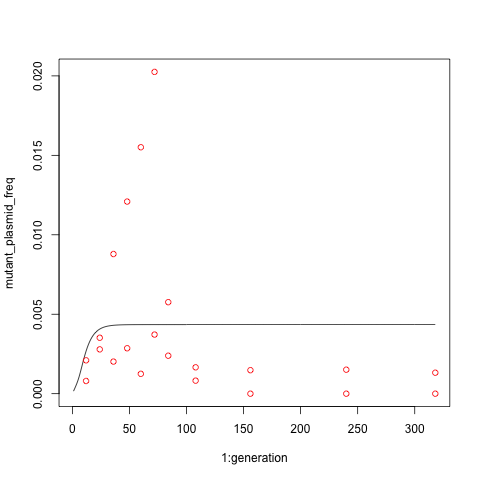

In [8]:
%%R 
theta_optimized=res$par
#theta_optimized=c(2.434101e-04, 2.260972e+00, 2.402614e+00, 8.997944e-01, 2.039318e+01, 2.719514e+01)
generation=318
mutant_plasmid_freq=rep(-1,generation)
nt=nt_init

trajectory = function (theta){
    u=theta[1]
    r=theta[2]
    R=theta[3]
    S=theta[4]
    m_optimal=round(theta[5]) # m_optimal needs to be integer!
    m_lethal=round(theta[6])  # m_lethal needs to be integer!
        
    for (i in 1:generation){
        nt_div=cell_division(nt)
        nt_growth=plasmid_replication_mutation(nt_div,u,r,R)
        nt_selection=cell_selection(nt_growth, S, m_optimal, m_lethal)
        mutant_plasmid_freq[i]=fcell_2_fplasmid(nt_selection)
        nt=nt_selection     
    } 
    plot (1:generation,mutant_plasmid_freq,type='l',ylim=range(c(mutant_plasmid_freq,emperical_data$frequency)))
    points (emperical_generations,emperical_data$frequency,col='red')
    print (mutant_plasmid_freq)
    return(nt)
}

nt_final=trajectory(theta_optimized)

[1] "nt_final:"
              m0           m1           m2           m3           m4
w0  0.000000e+00 0.000000e+00 1.111958e+85 0.000000e+00 1.028879e+85
w1  0.000000e+00 9.773465e+83 0.000000e+00 1.568864e+81 0.000000e+00
w2  3.992020e+87 0.000000e+00 6.408795e+84 0.000000e+00 4.372574e+84
w3  0.000000e+00 2.470708e+84 0.000000e+00 4.632036e+81 0.000000e+00
w4  5.045865e+87 0.000000e+00 9.461272e+84 0.000000e+00 6.164104e+84
w5  0.000000e+00 3.952291e+84 0.000000e+00 9.325175e+81 1.159273e+74
w6  5.381109e+87 0.000000e+00 1.269715e+85 9.471076e+77 7.591443e+84
w7  0.000000e+00 0.000000e+00 3.868744e+81 0.000000e+00 1.084003e+79
w8  0.000000e+00 7.901279e+84 0.000000e+00 2.214183e+82 0.000000e+00
w9  6.454632e+87 0.000000e+00 1.809440e+85 0.000000e+00 1.016292e+85
w10 0.000000e+00 1.206014e+85 0.000000e+00 3.793295e+82 0.000000e+00
w11 8.210042e+87 0.000000e+00 2.583427e+85 0.000000e+00 1.393319e+85
w12 0.000000e+00 1.796413e+85 0.000000e+00 6.064946e+82 0.000000e+00
w13 1.048219e+88 0

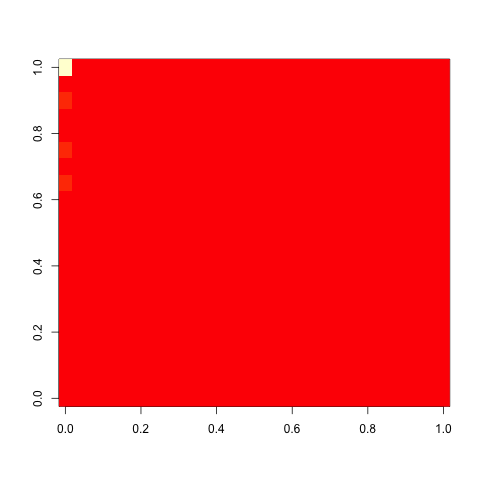

In [9]:
%%R
print("nt_final:")
print(nt_final)
print(paste0("sum(nt_final): ", sum(nt_final)))
image(t(nt_final))
wt_plasmid=sum(nt_final*(0:w_max))
mutant_plasmid=sum(t(nt_final)*(0:m_max))
print(paste0("wt_plasmid: ", wt_plasmid))
print(paste0("mutant_plasmid: ", mutant_plasmid))
print(paste0("mutant_plasmid/(wt_plasmid+mutant_plasmid): ", mutant_plasmid/(wt_plasmid+mutant_plasmid)))